# Mask R-CNN - Train and Test on Shapes Dataset


This notebook shows how to train Mask R-CNN on DIY Facade dataset(165 samples). It still need a GPU, though, because the network backbone is a Resnet50, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in several hours(less then 6 hours).
 

In [1]:
import os
os.sys.path
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import yaml
from PIL import Image
import tensorflow as tf
from skimage import morphology
from datetime import datetime 
import skimage.io

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

iter_num = 0

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (20, 40, 80, 160, 320)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 20

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 83

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class FacadeDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    # 得到该图中有多少个实例（物体）
    def get_obj_index(self, image):
        n = np.max(image)
        return n
    
    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签 
    def from_yaml_get_class(self, image_id): 
        info = self.image_info[image_id] 
        with open(info['yaml_path']) as f: 
            temp = yaml.load(f.read()) 
            labels = temp['label_names'] 
            del labels[0] 
        return labels
    
    # 重新写draw_mask 
    def draw_mask(self, num_obj, mask, image,image_id): 
        #print("draw_mask-->",image_id) 
        #print("self.image_info",self.image_info) 
        info = self.image_info[image_id] 
        #print("info-->",info) 
        #print("info[width]----->",info['width'],"-info[height]--->",info['height']) 
        for index in range(num_obj): 
            for i in range(info['width']): 
                for j in range(info['height']): 
                    #print("image_id-->",image_id,"-i--->",i,"-j--->",j) 
                    #print("info[width]----->",info['width'],"-info[height]--->",info['height']) 
                    at_pixel = image.getpixel((i, j)) 
                    if at_pixel == index + 1: 
                        mask[j, i, index] = 1 
        return mask
    
    # 重新写load_shapes，里面包含自己的类别,可以任意添加 
    # 并在self.image_info信息中添加了path、mask_path 、yaml_path 
    # yaml_pathdataset_root_path = "/tongue_dateset/" 
    # img_floder = dataset_root_path + "rgb" 
    # mask_floder = dataset_root_path + "mask" 
    # dataset_root_path = "/tongue_dateset/" 
    def load_shapes(self, count, imglist,dataset_root_path): 
        """Generate the requested number of synthetic images.
    count: number of images to generate.
    height, width: the size of the generated images.
    """ 
        # Add classes,可通过这种方式扩展多个物体 
        self.add_class("shapes", 1, "facade") # building facade
        for i in range(count):
            # 获取图片宽和高 
            filestr = imglist[i].split(".")[0] 
            #print(imglist[i],"-->",cv_img.shape[1],"--->",cv_img.shape[0]) 
            #print("id-->", i, " imglist[", i, "]-->", imglist[i],"filestr-->",filestr) 
            #filestr = filestr.split("_")[1] 
            mask_path = dataset_root_path + filestr + "/label_grey.png" 
            yaml_path = dataset_root_path + filestr + "/info.yaml" 
            #print(dataset_root_path + filestr + "_json/img.png") 
            cv_img = cv2.imread(dataset_root_path + filestr + "/img.png") 

            self.add_image("shapes", image_id=i, path=dataset_root_path +  filestr + "/img.png", 
                           width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)


    # 重写load_mask 
    def load_mask(self, image_id): 
        """Generate instance masks for shapes of the given image ID.
        """ 
        global iter_num 
        print("image_id",image_id) 
        info = self.image_info[image_id] 
        
        img = Image.open(info['mask_path']) 
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8) 
        mask = self.draw_mask(num_obj, mask, img,image_id) 
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8) 
        for i in range(num_obj - 1, -1, -1): 
            mask[:, :, i] = mask[:, :, i] * occlusion 
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i])) 
        labels = [] 
        labels = self.from_yaml_get_class(image_id) 
        labels_form = [] 
        for i in range(len(labels)): 
            if labels[i].find("facade") != -1: 
                # print "box" 
                labels_form.append("facade") 
        class_ids = np.array([self.class_names.index(s) for s in labels_form]) 
        return mask, class_ids.astype(np.int32)

## Data Preparing

In [4]:
#基础设置 
dataset_root_path = "labelme_json/"
imglist = os.listdir(dataset_root_path)
count = len(imglist)

#train与val数据集准备 
dataset_train = FacadeDataset() 
dataset_train.load_shapes(count, imglist,dataset_root_path) 
dataset_train.prepare() 

#print("dataset_train-->",dataset_train._image_ids) 
dataset_val = FacadeDataset() 
dataset_val.load_shapes(7, imglist,dataset_root_path) 
dataset_val.prepare()


## Train Process

In [1]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
# Which weights to start with? 
init_with = "coco" # imagenet, coco, or last 

if init_with == "imagenet": 
    model.load_weights(model.get_imagenet_weights(), by_name=True) 
elif init_with == "coco": 
    # Load weights trained on MS COCO, but skip layers that 
    # are different due to the different number of classes 
    # See README for instructions to download the COCO weights 
    model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]) 

elif init_with == "last": 
    # Load the last model you trained and continue training 
    model.load_weights(model.find_last()[1], by_name=True) 
    
# Train the head branches 
# Passing layers="heads" freezes all layers except the head 
# layers. You can also pass a regular expression to select 
# which layers to train by name pattern. 
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=20, layers='heads') 

# Fine tune all layers 
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to 
# train by name pattern. 
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE / 10, epochs=30, layers="all")

NameError: name 'modellib' is not defined

## Varified Results

In [6]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 6)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

image_id 0


NameError: name 'model' is not defined

## Test Process

(510, 711, 3)
Processing 1 images
image                    shape: (510, 711, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  711.00000  float64
anchors                  shape: (1, 36828, 4)         min:   -0.59079  max:    1.42369  float32
shijian 2


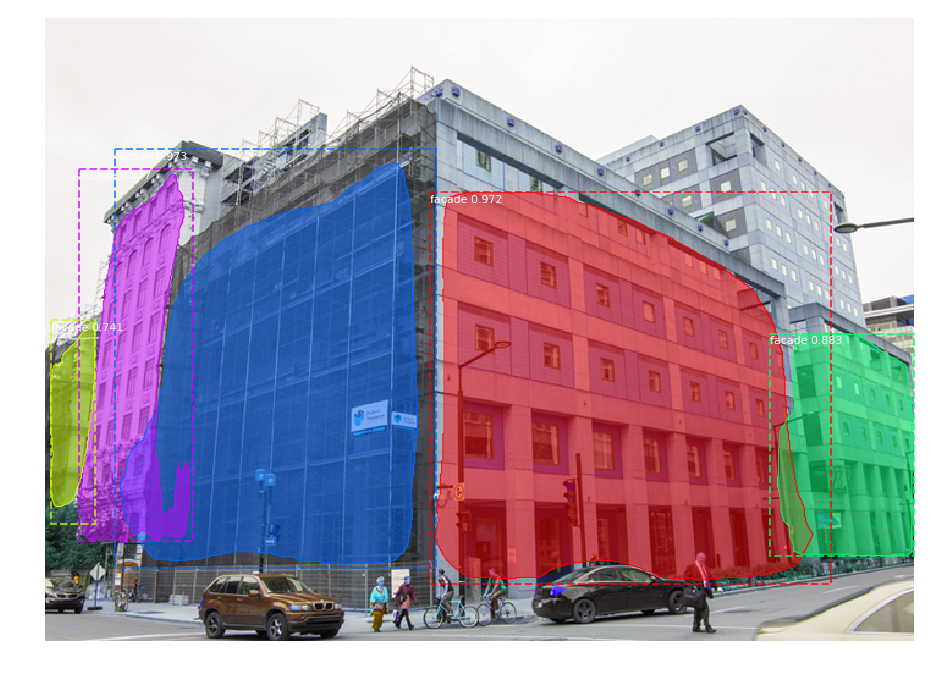

In [18]:
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
from samples.coco import coco
# Local path to trained weights file 
COCO_MODEL_PATH = os.path.join(MODEL_DIR ,"mask_rcnn_shapes_0030.h5") 
# Download COCO trained weights from Releases if needed 
if not os.path.exists(COCO_MODEL_PATH): 
    utils.download_trained_weights(COCO_MODEL_PATH) 
    print("Downloading***********************")

IMAGE_DIR = "test"
class InferenceConfig(ShapesConfig): 
    # Set batch size to 1 since we'll be running inference on 
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU 
    GPU_COUNT = 1 
    IMAGES_PER_GPU = 1 

config = InferenceConfig() 
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config) 

# Create model object in inference mode. 
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config) 
# Load weights trained on MS-COCO 
model.load_weights(COCO_MODEL_PATH, by_name=True) 
# COCO Class names 
# Index of the class in the list is its ID. For example, to get ID of 
# the teddy bear class, use: class_names.index('teddy bear') 
class_names = ['BG', 'facade']
# Load a random image from the images folder 
file_names = next(os.walk(IMAGE_DIR))[2] 
image = cv2.imread(os.path.join(IMAGE_DIR, random.choice(file_names)),1)
# image = cv2.imread("test/image.png", 1)
# image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
print(image.shape) 

img_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
# img_gray = cv2.GaussianBlur(img_gray,(3,3),0)
a=datetime.now() 
# Run detection 
results = model.detect([image], verbose=1) 
b=datetime.now() 
# Visualize results 
print("shijian",(b-a).seconds) 
r = results[0] 
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])


# Mask & Edges the Building Part

w= 157  h= 336
0.15407795771369773


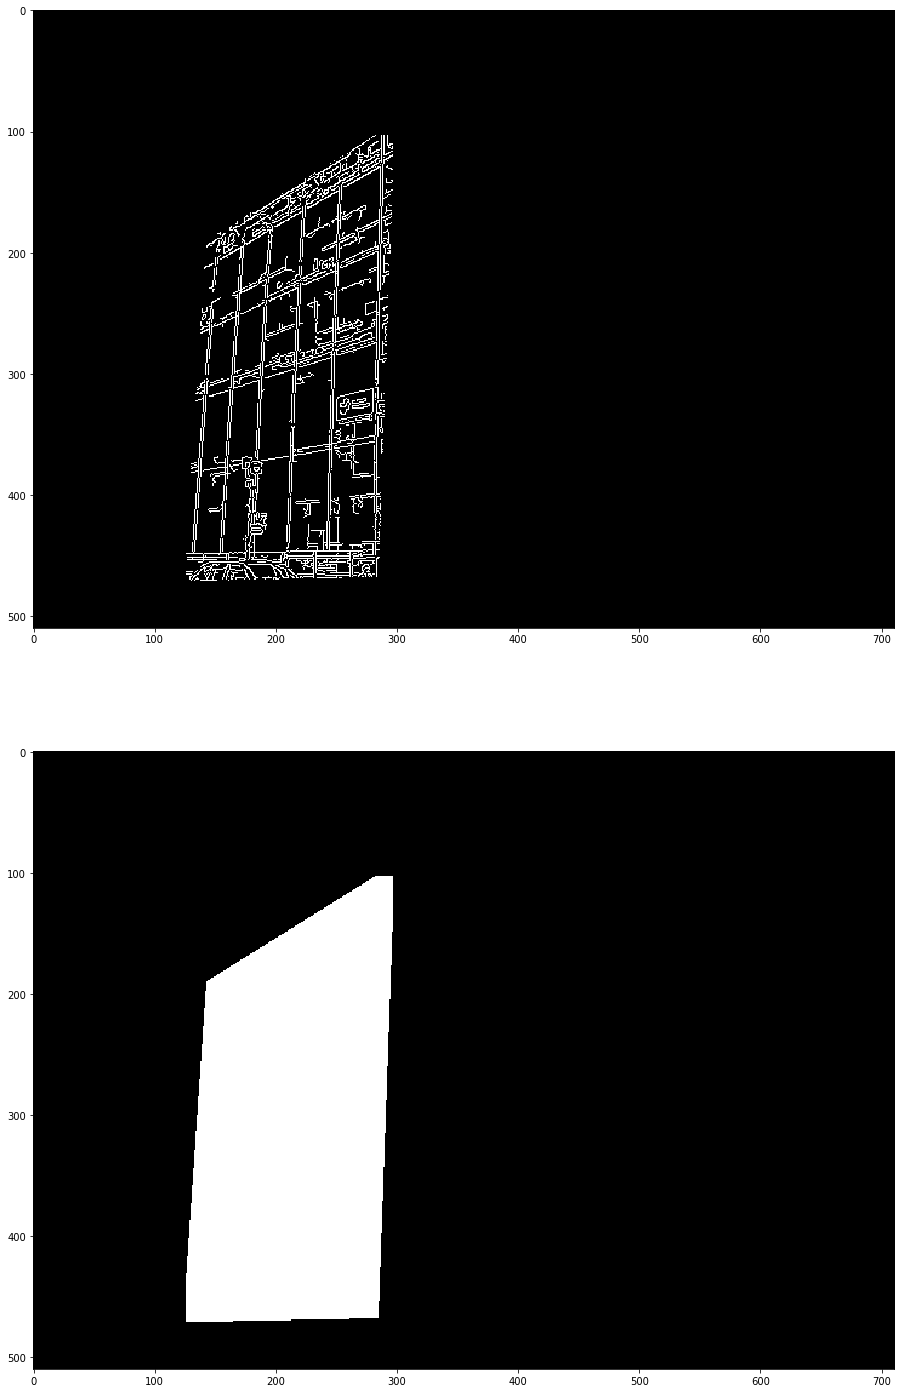

w= 296  h= 299
0.1793879878986262


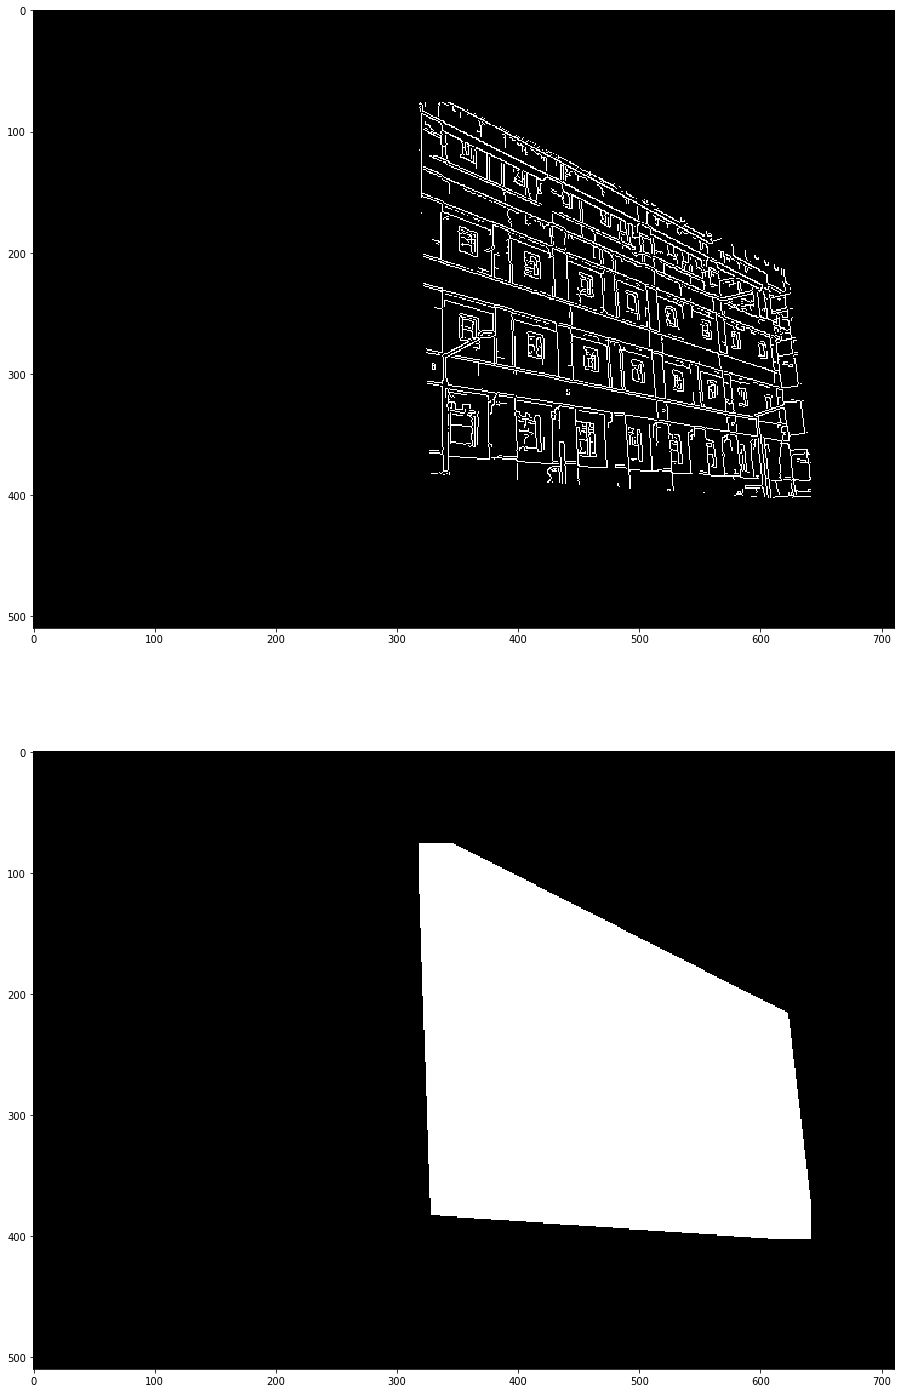

w= 101  h= 161
0.2178246013667426


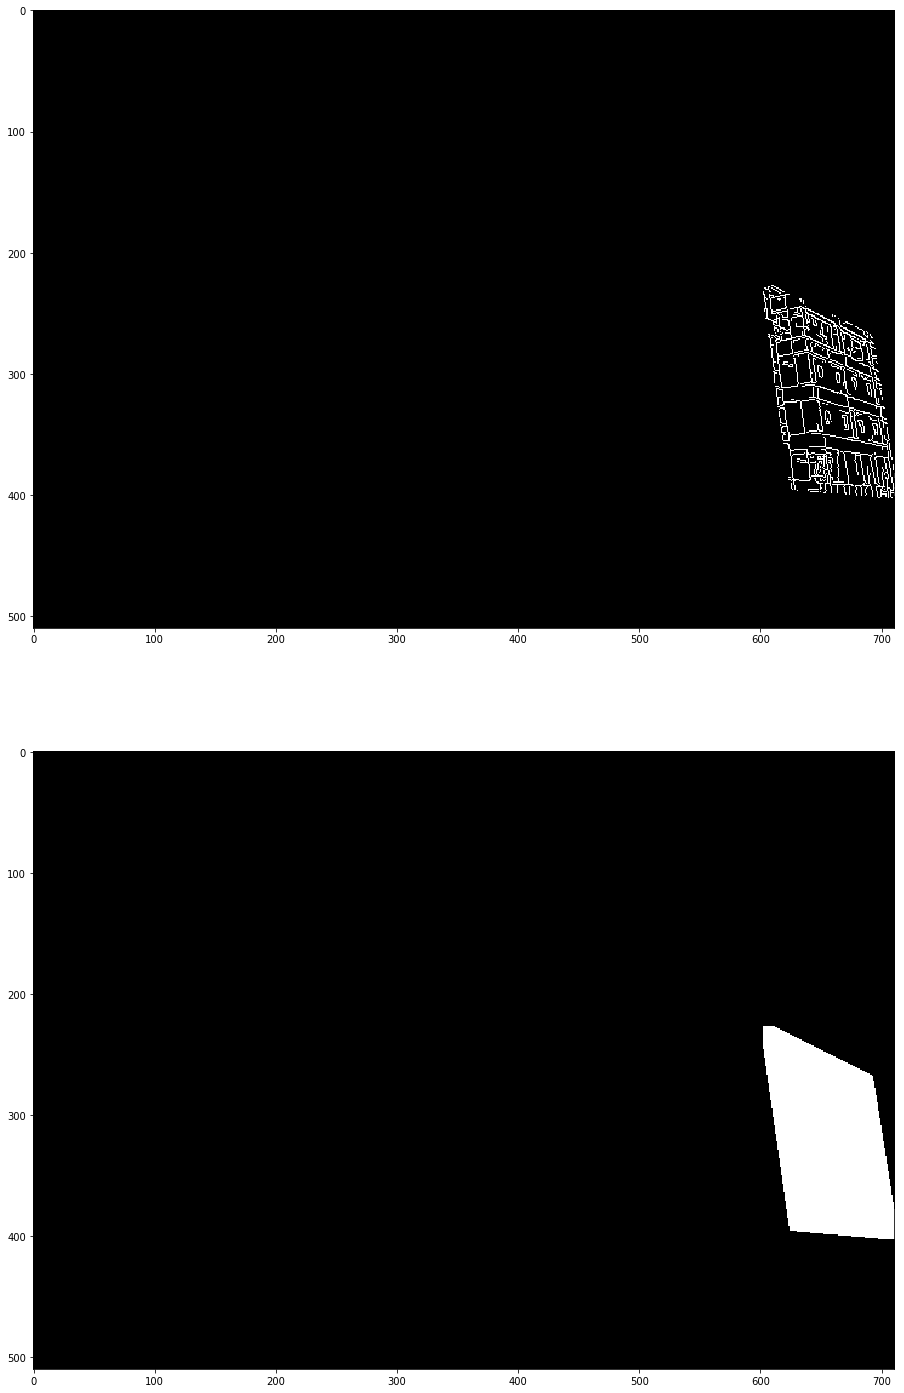

w= 75  h= 233
0.30320955197721544


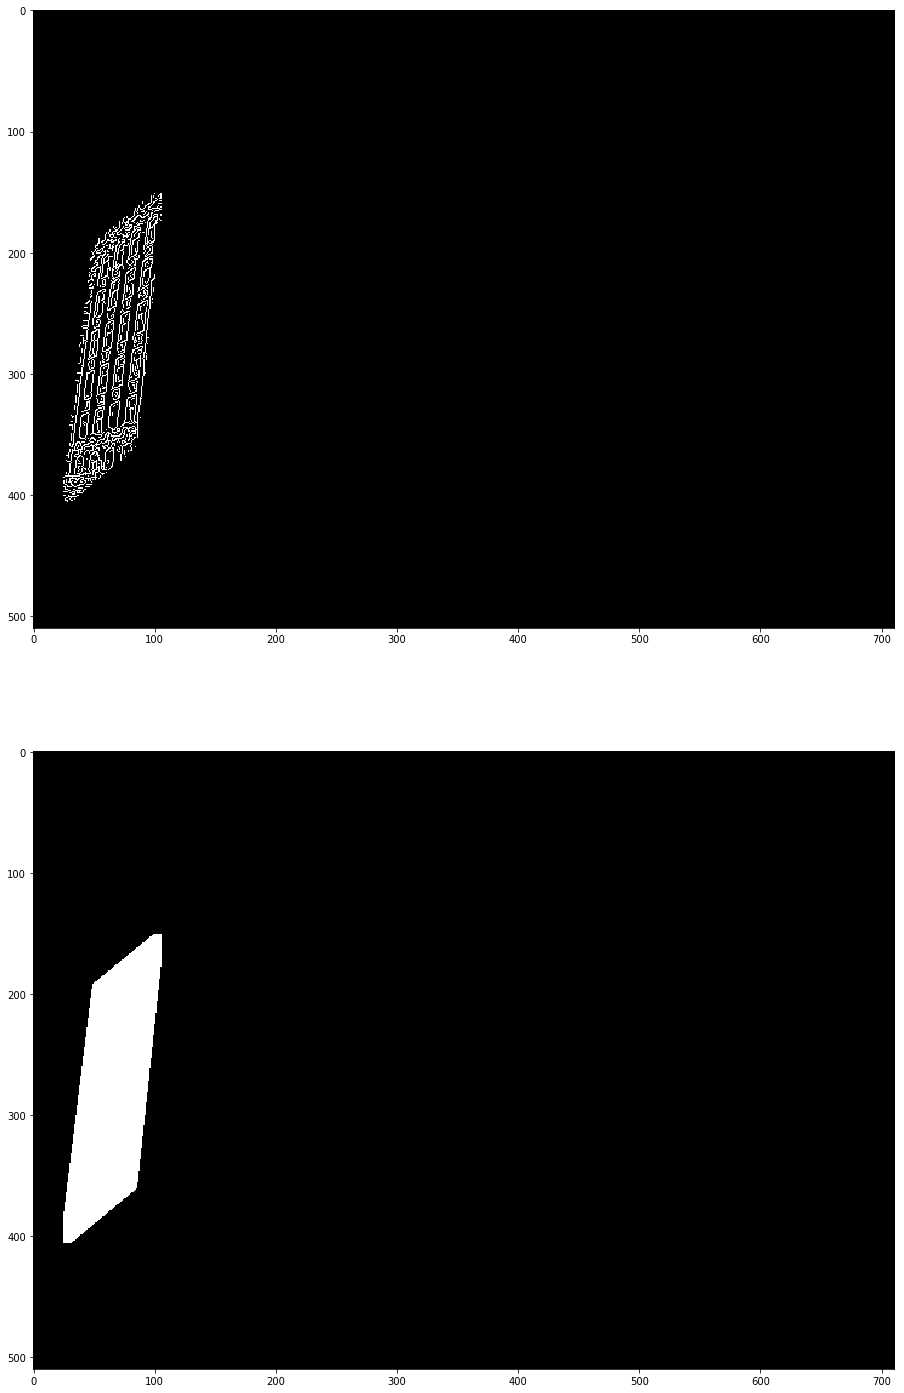

w= 22  h= 46
0.2488822652757079


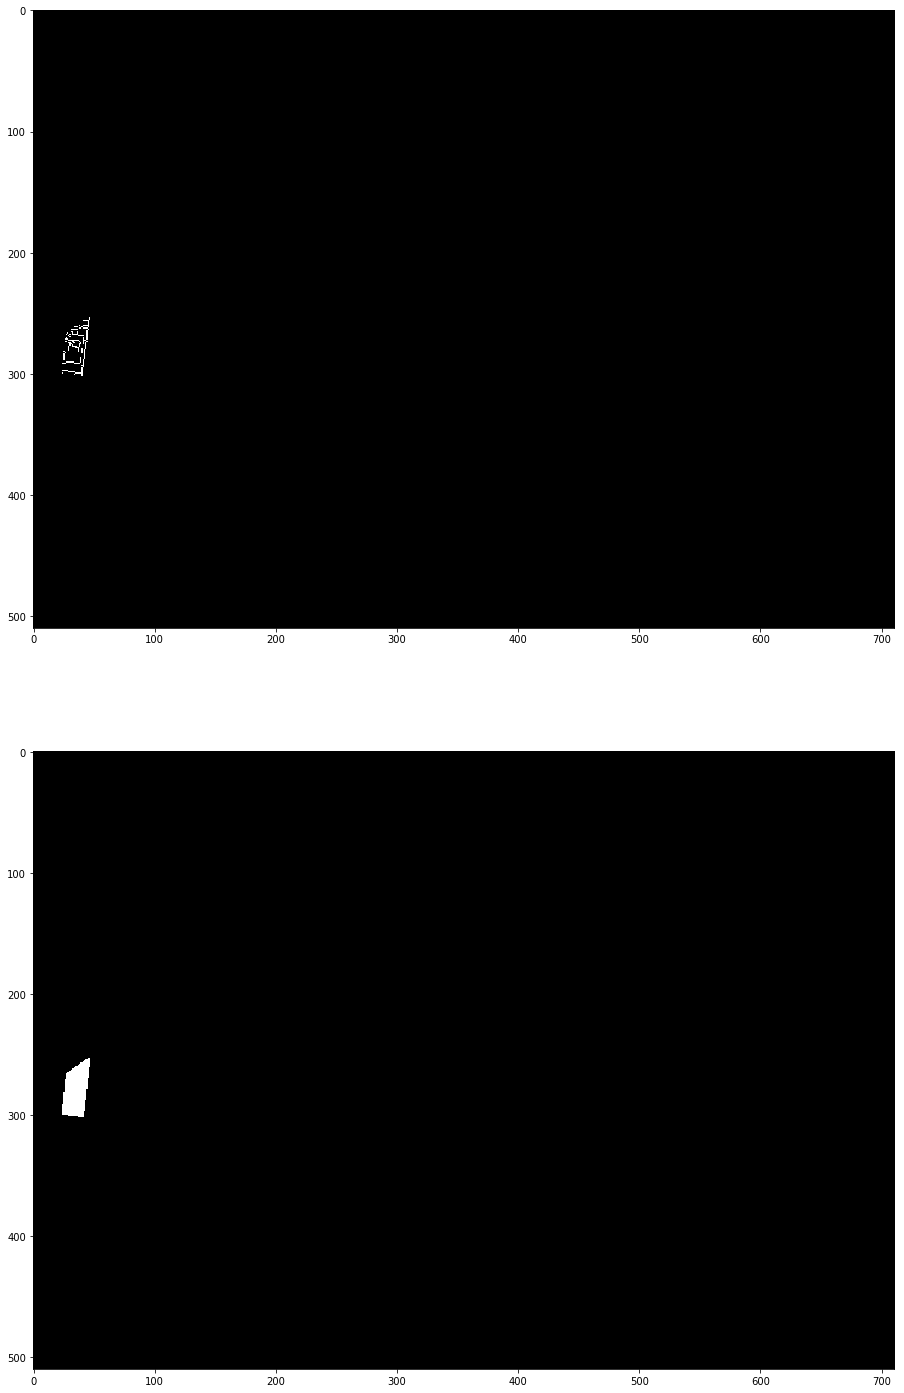

In [21]:
def area(image):
    area = 0
    height, width = image.shape
    for i in range(height): 
        for j in range(width): 
            if image[i, j] == 1: 
                area += 1 
    return area
    
facades_mask = []
facades_w = []
facades_h =[]
for i in range(len(r['masks'][0,0,:])):
    mask = r['masks'][:,:,i] 
    
    w = np.sum(np.max(mask, axis=0))
    facades_w.append(w)
    h = np.sum(np.max(mask, axis=1))
    facades_h.append(h)
    print("w=",w, " h=",h)
    
    kernel = np.ones((int(h/10),int(w/10)),np.uint8)
    mask = mask.astype('uint8')
    dilation = cv2.dilate(mask,kernel,iterations = 1)
    mask_work = dilation
    
    # building edges
    edgs_detail = cv2.Canny(img_gray, 50, 150, apertureSize = 3)

    # building mask
    building_mask = np.bitwise_and(edgs_detail, dilation)
    
    # density of building
    mask_area = area(mask)
    builde_area = area(np.bitwise_and(edgs_detail, mask))
    density = builde_area/mask_area
    print(density)

    if w > len(image[0])/4 and density > 0.20:
        kernel2 = np.ones((int(h/10),int(w/3)),np.uint8)
        mask_erode = cv2.erode(mask,kernel2,iterations = 1)
        mask_work= np.bitwise_xor(mask_erode,dilation)

    # building facade part
    building_details = np.bitwise_and(edgs_detail,mask_work)
    
    facades_mask.append(building_details)

    fig, axes = plt.subplots(2,1,figsize=(25,25))
    ax0, ax1 = axes.ravel()

    ax0.imshow(building_mask,plt.cm.gray)

    ax1.imshow(mask_work,plt.cm.gray)

    plt.show()


# Vertical & Horizontal Lines

(510, 711)
33 40 8 9


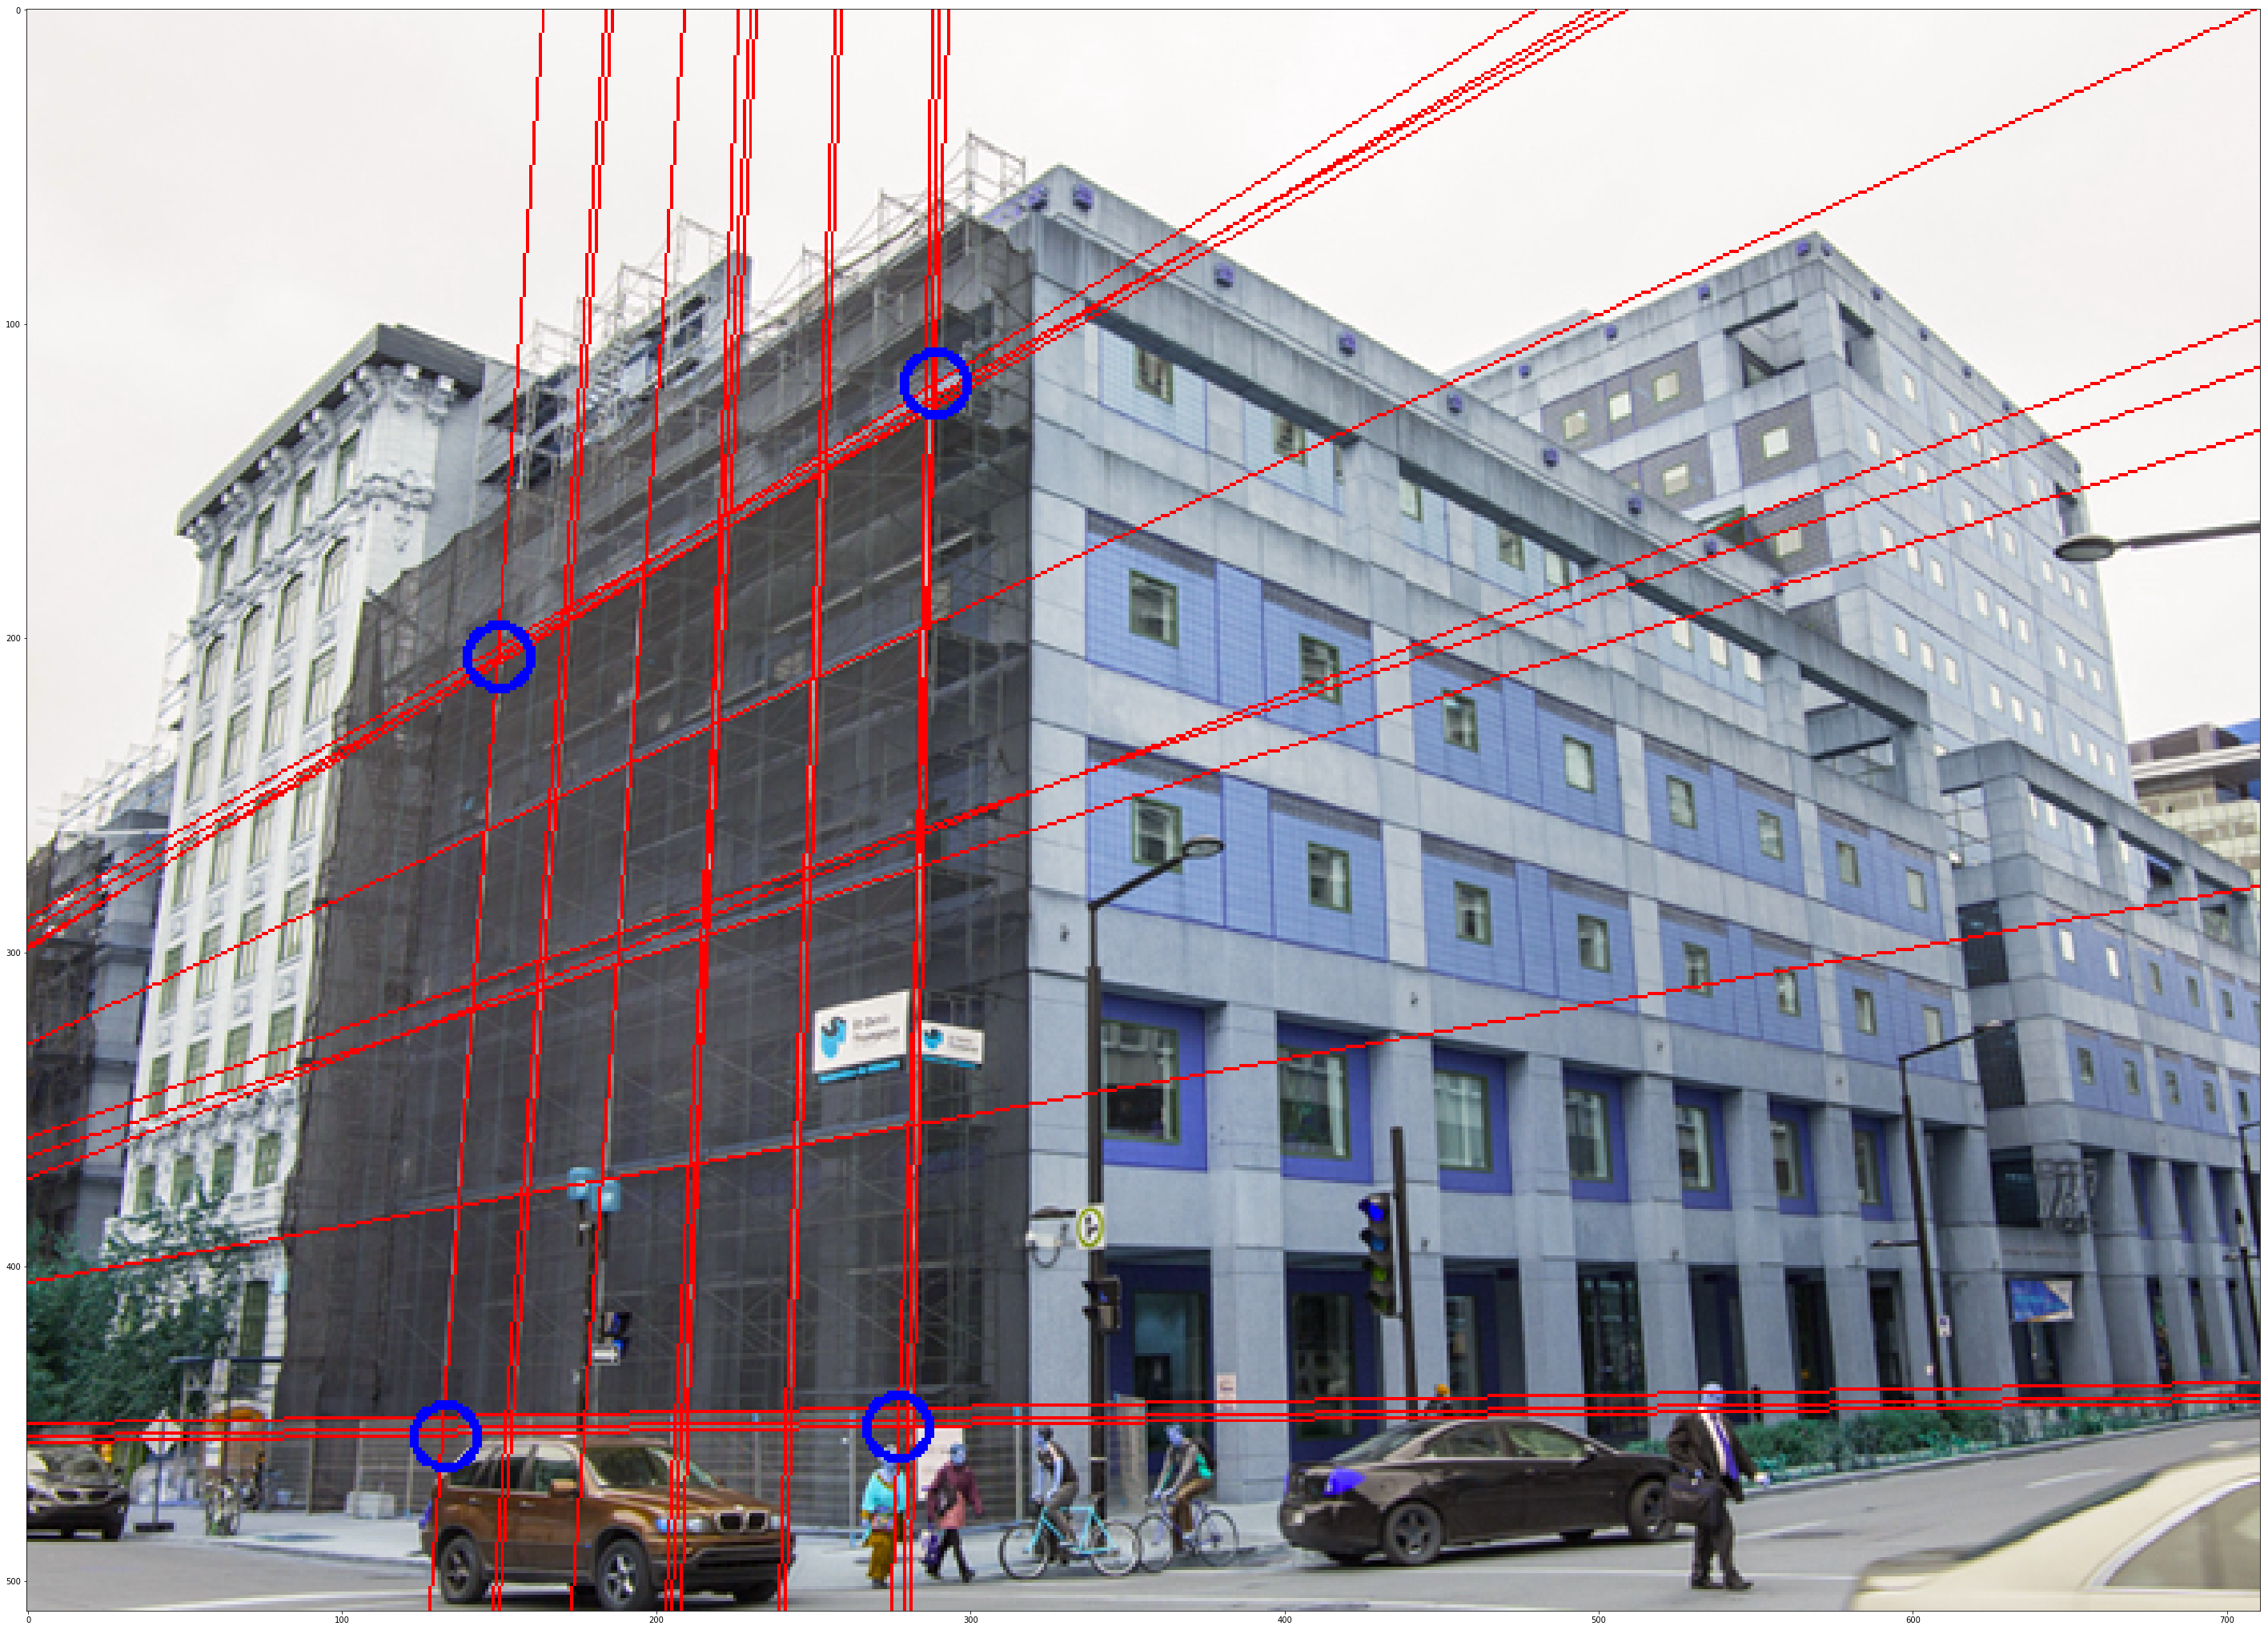

(510, 711)
20 9 42 14


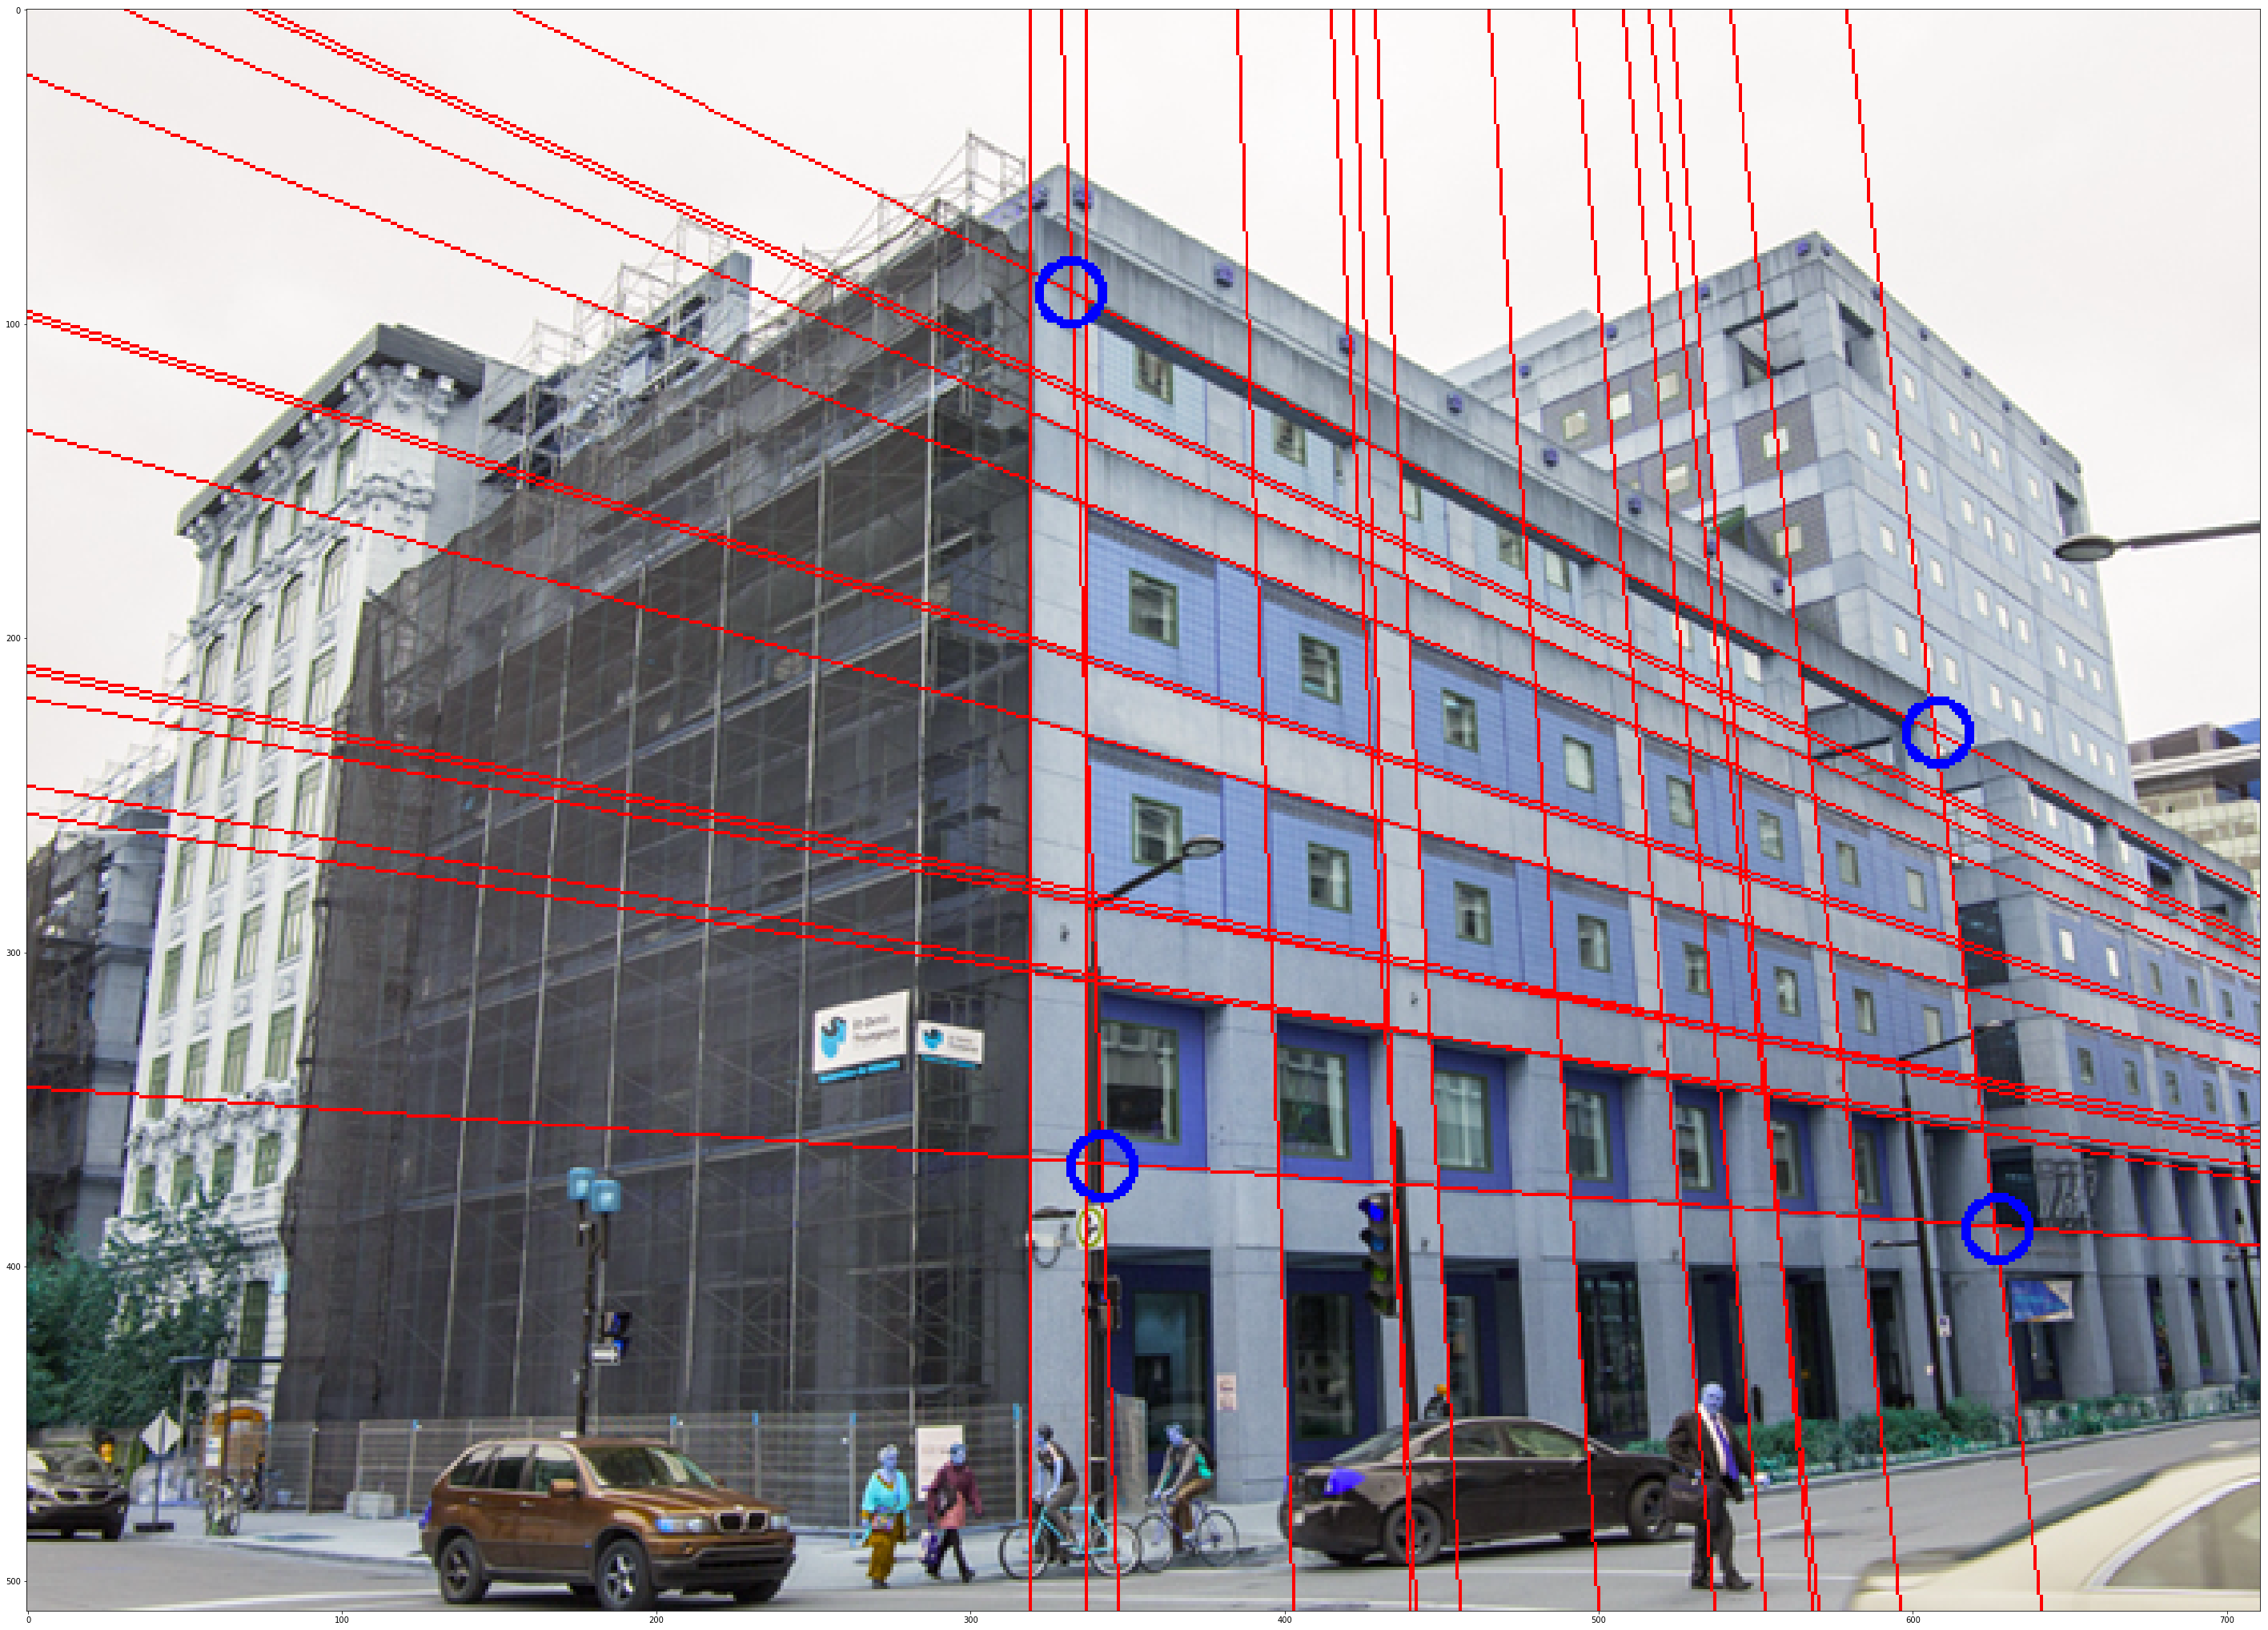

(510, 711)
129 128 5 2


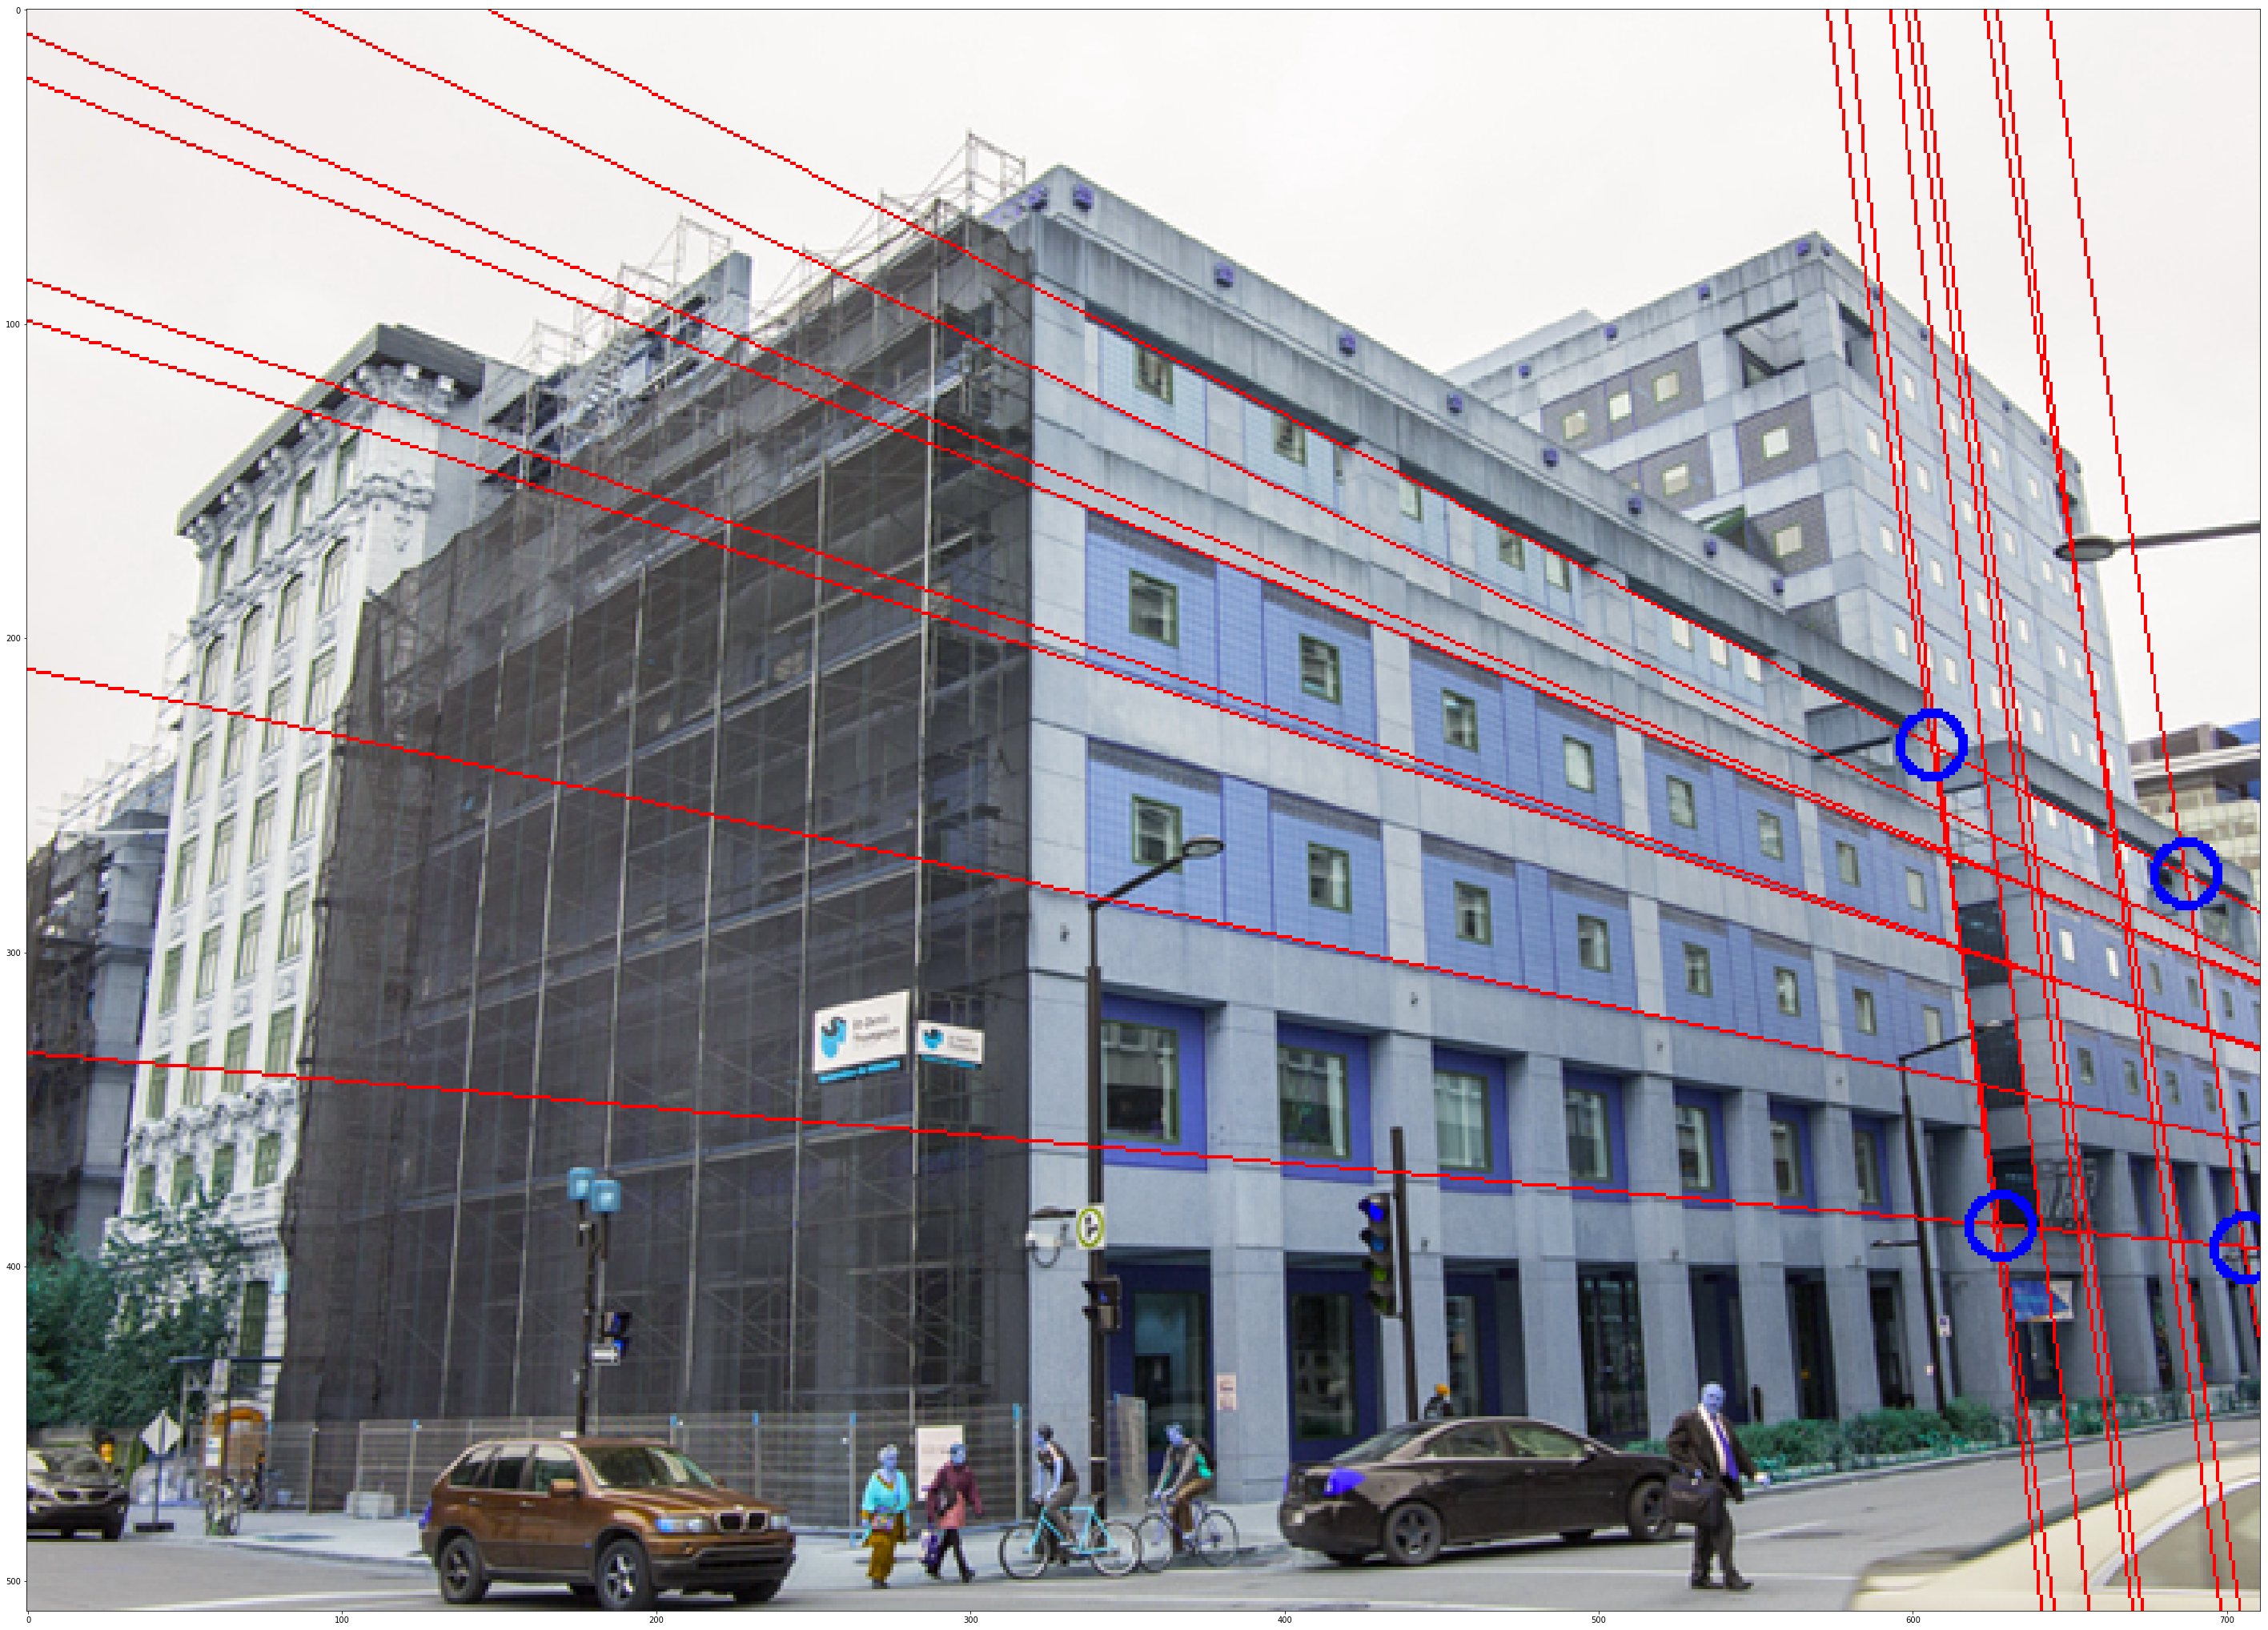

(510, 711)
919 1101 2 3


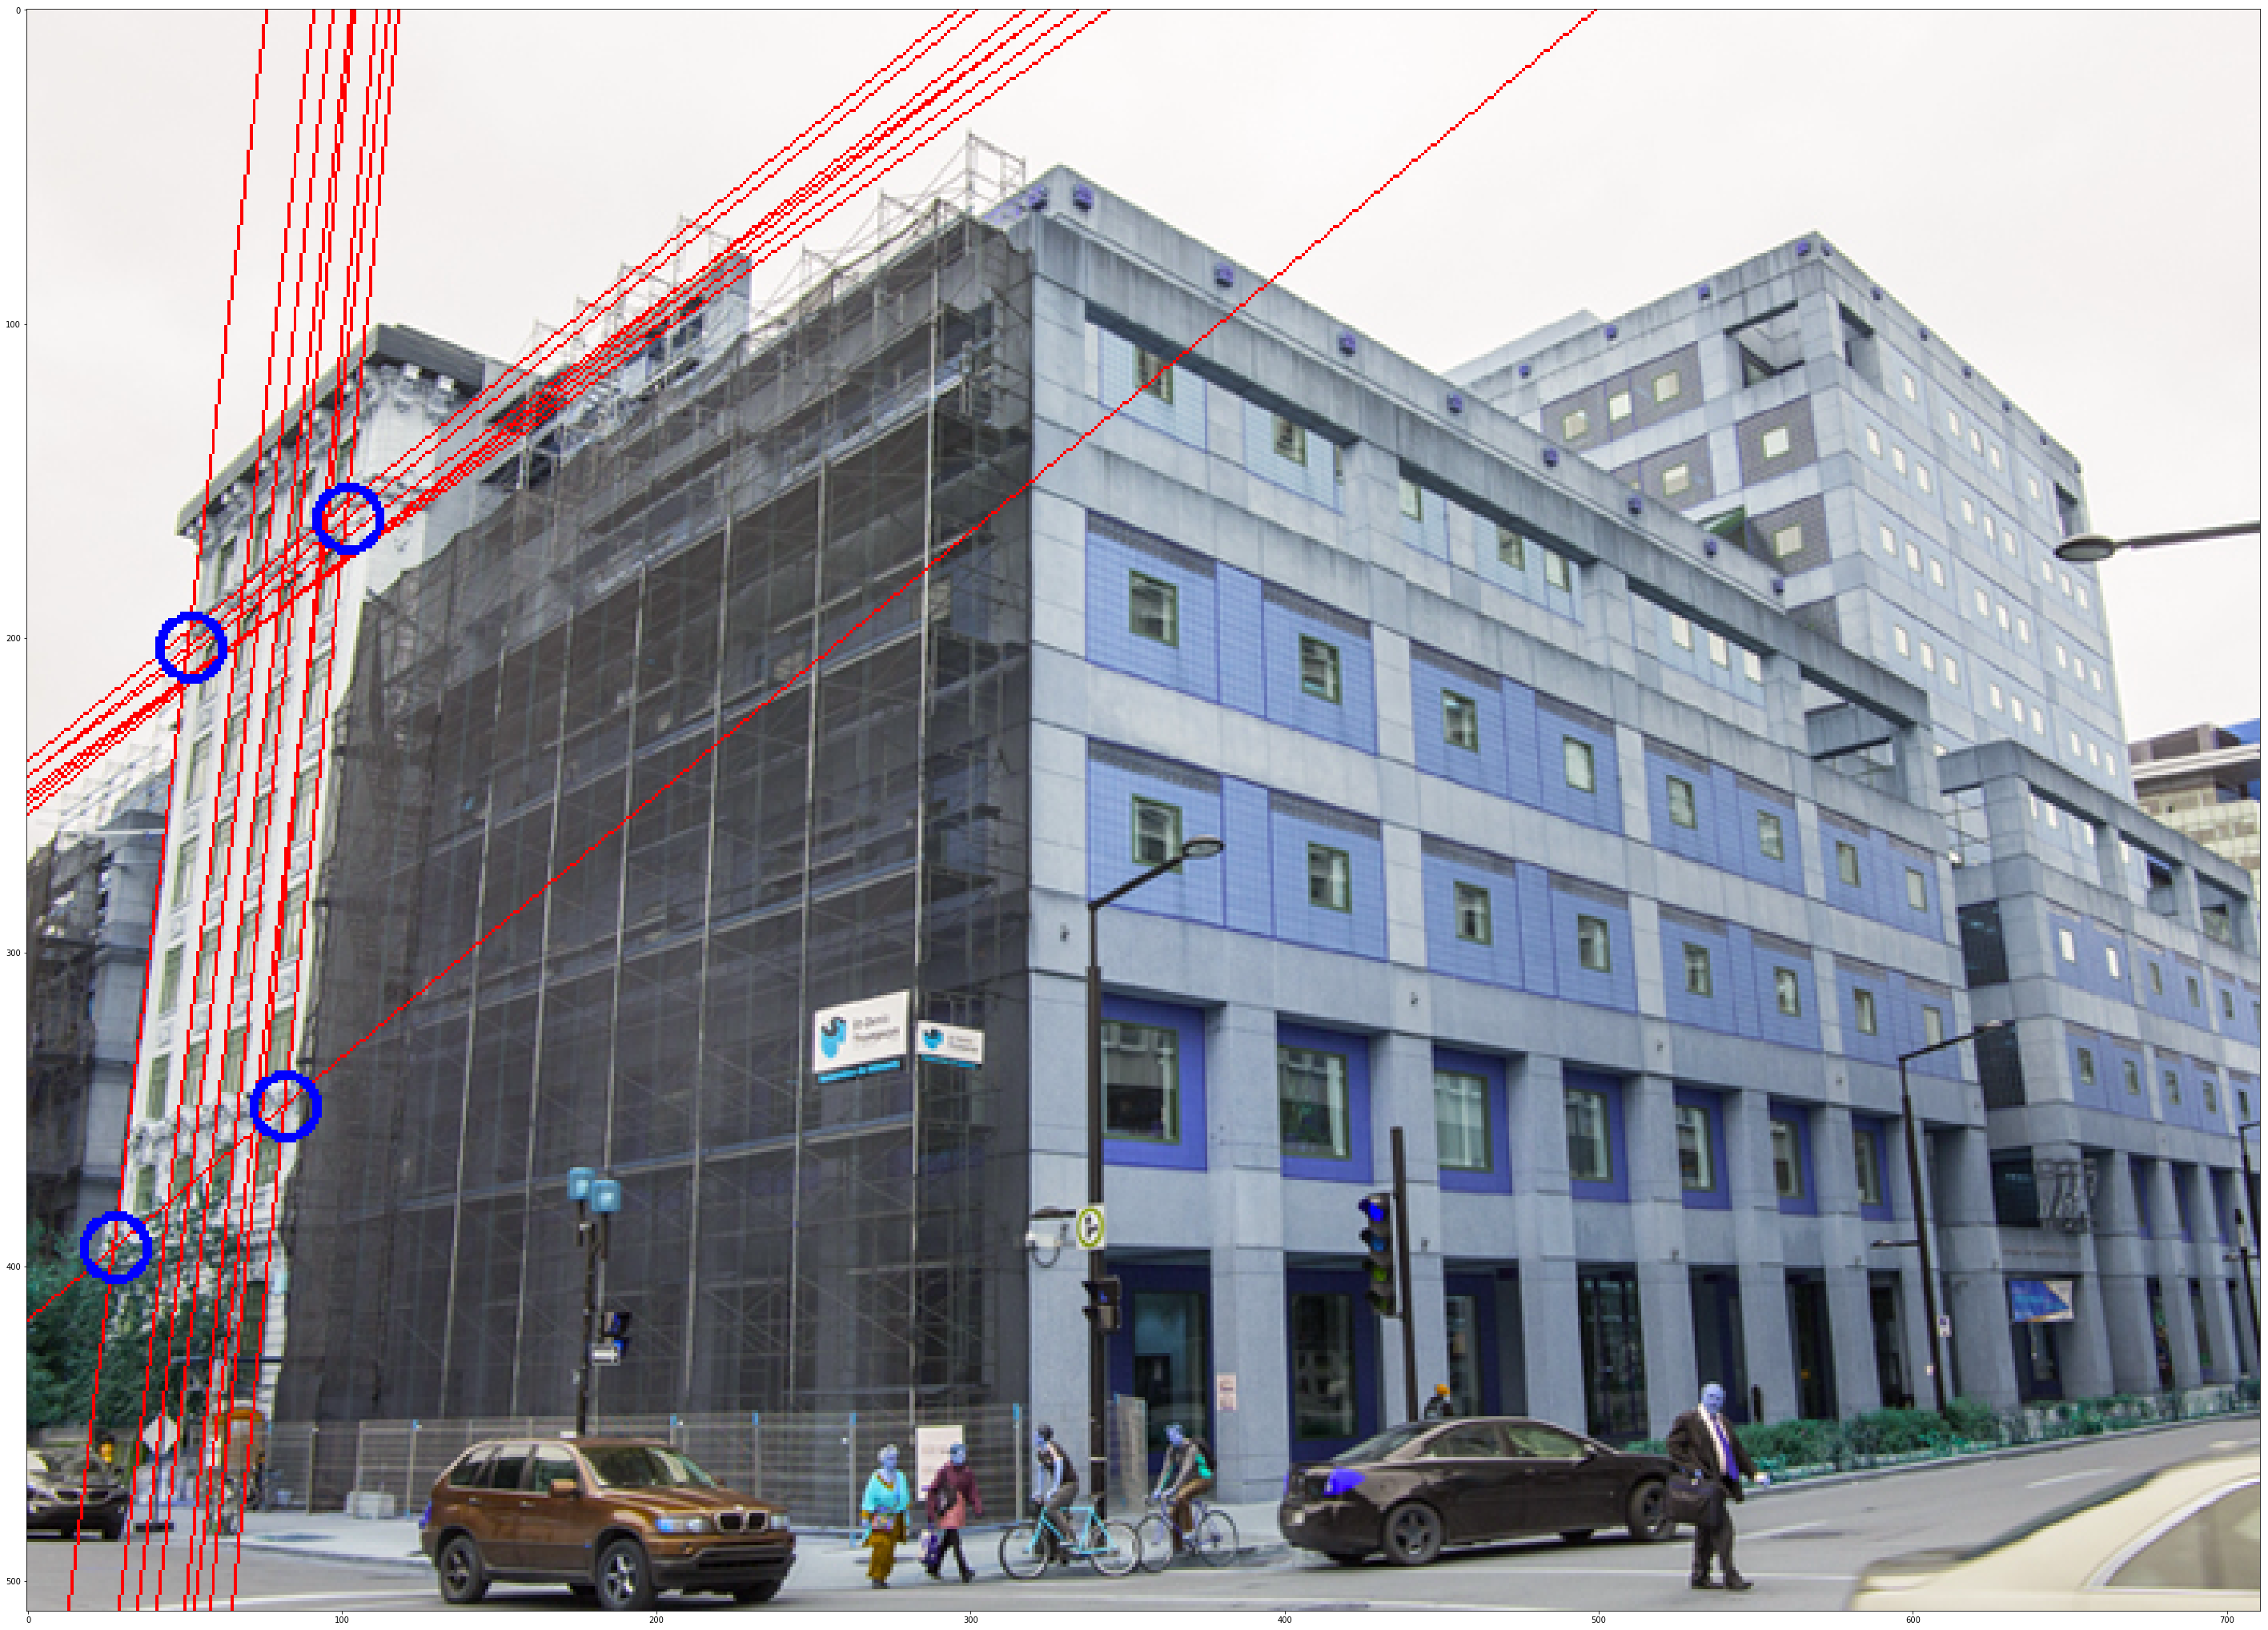

(510, 711)
315 249 3 0


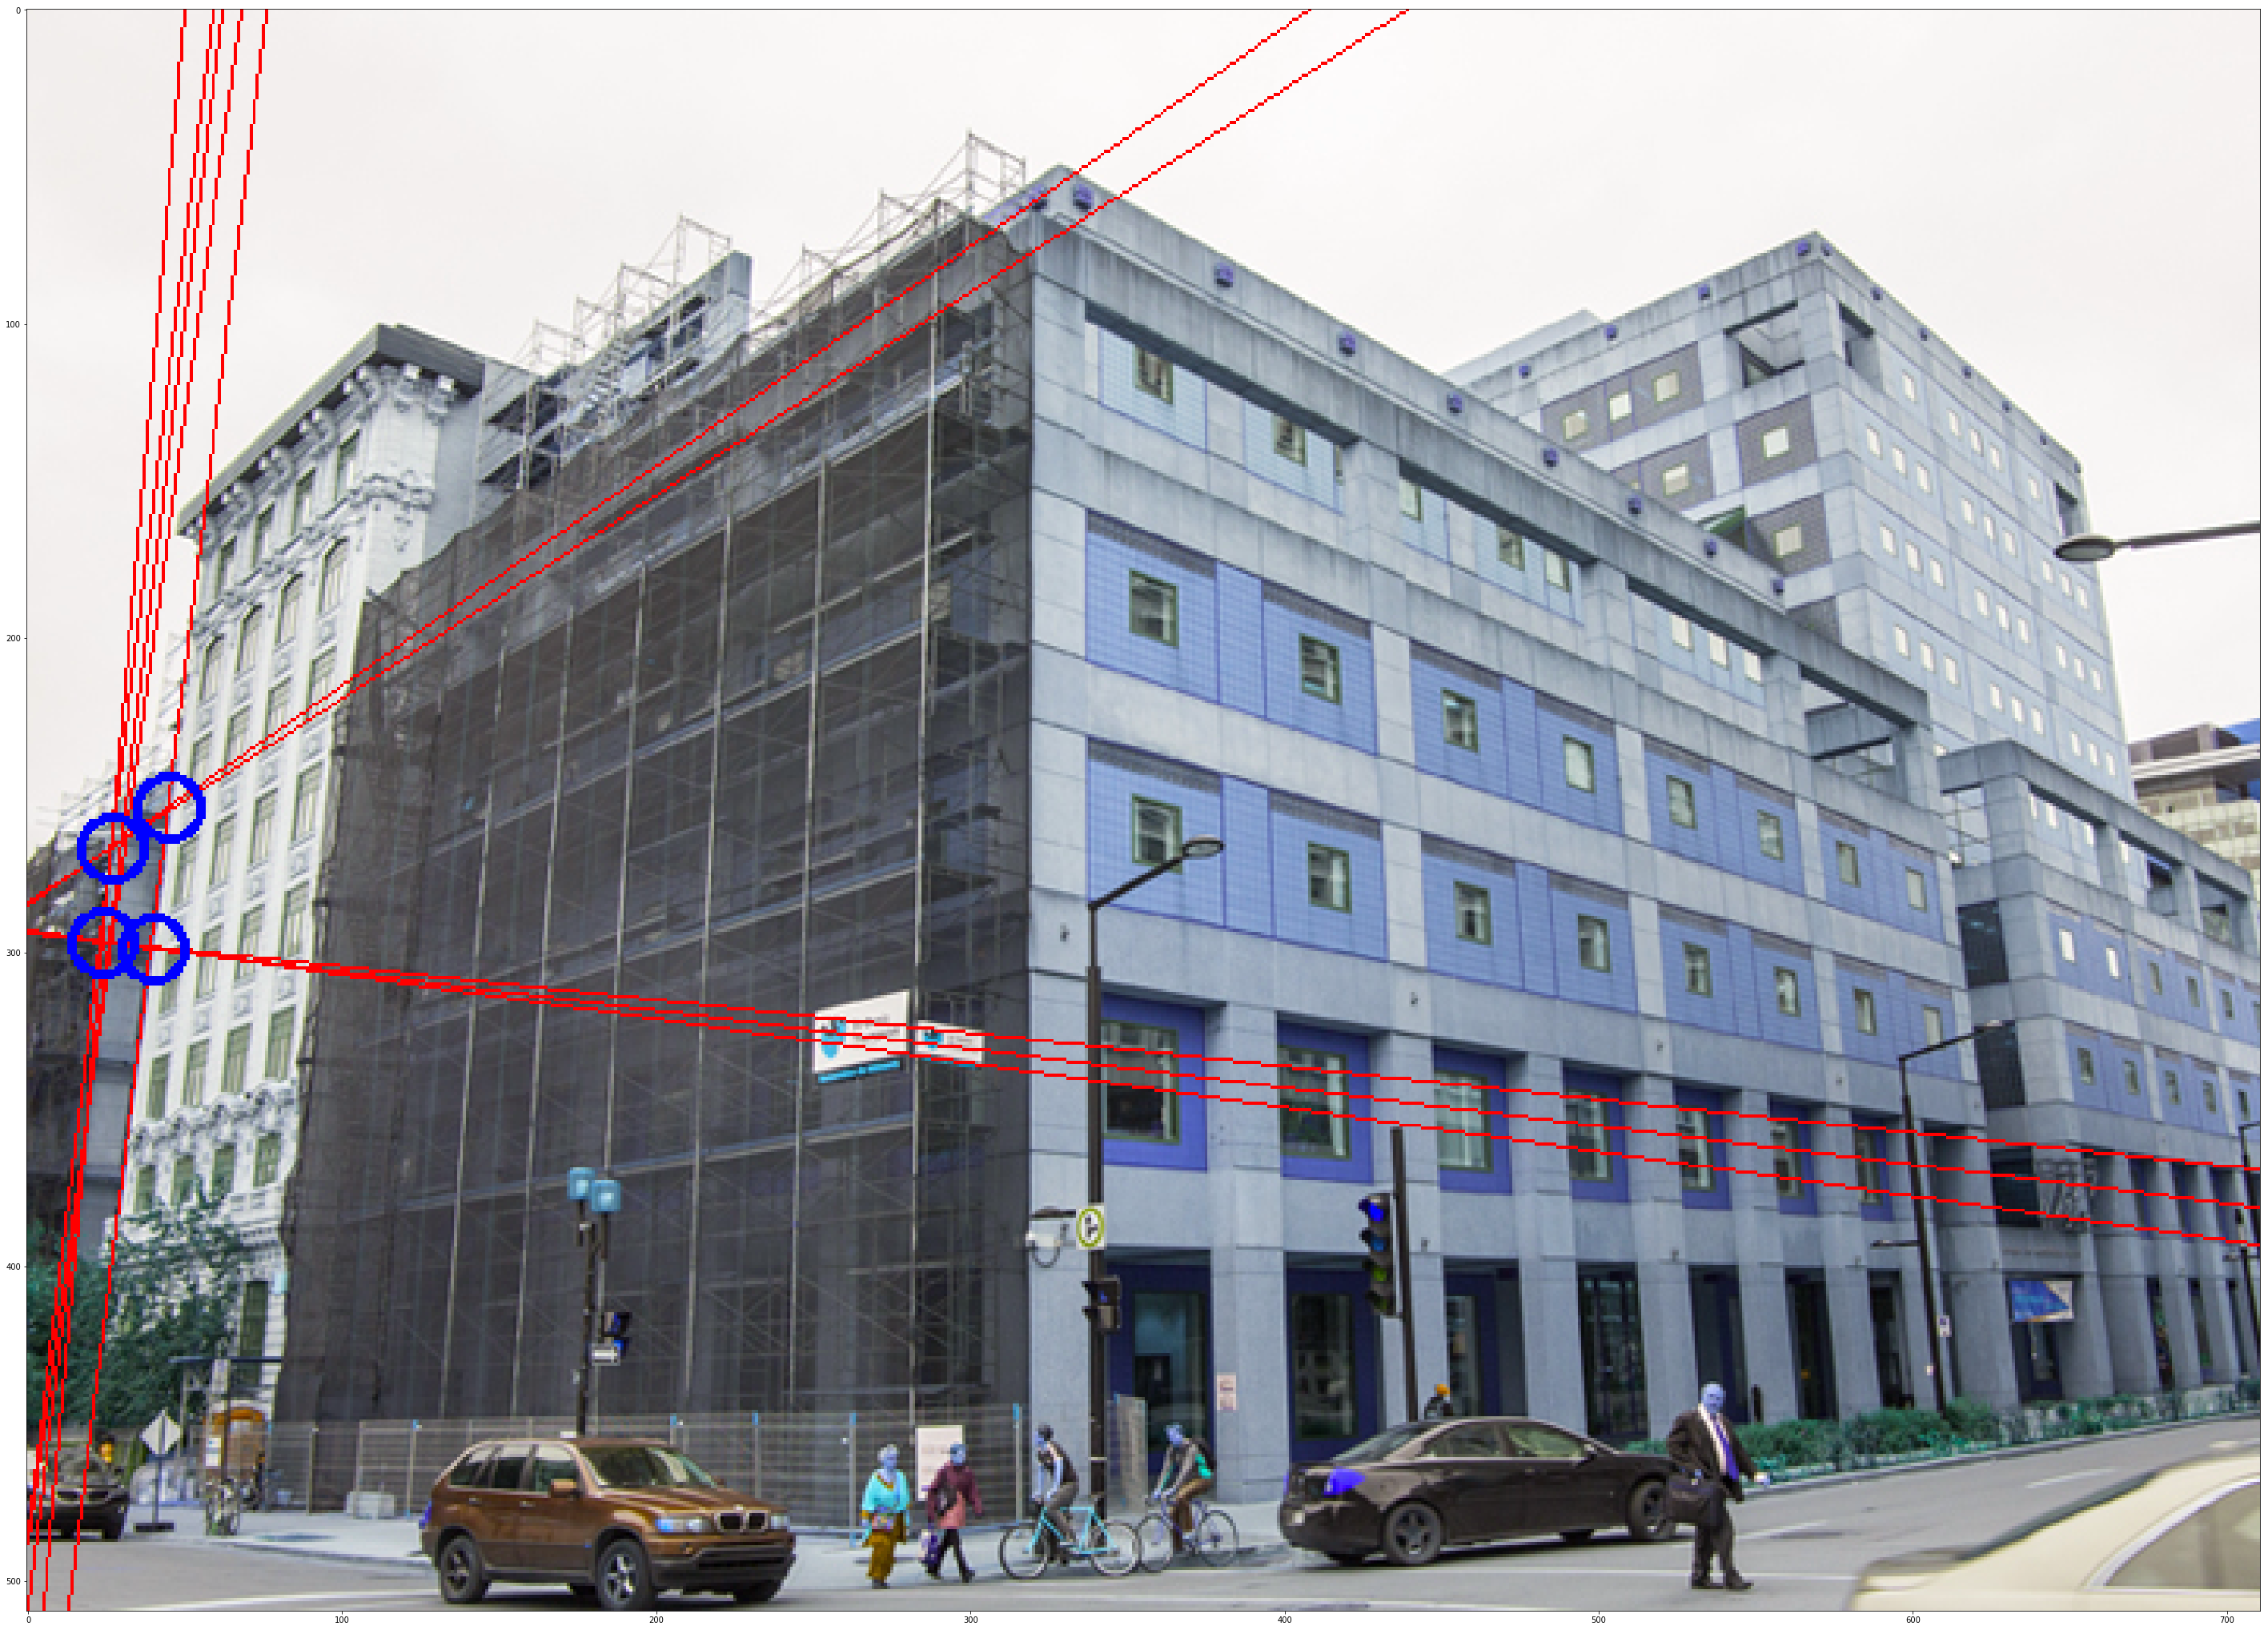

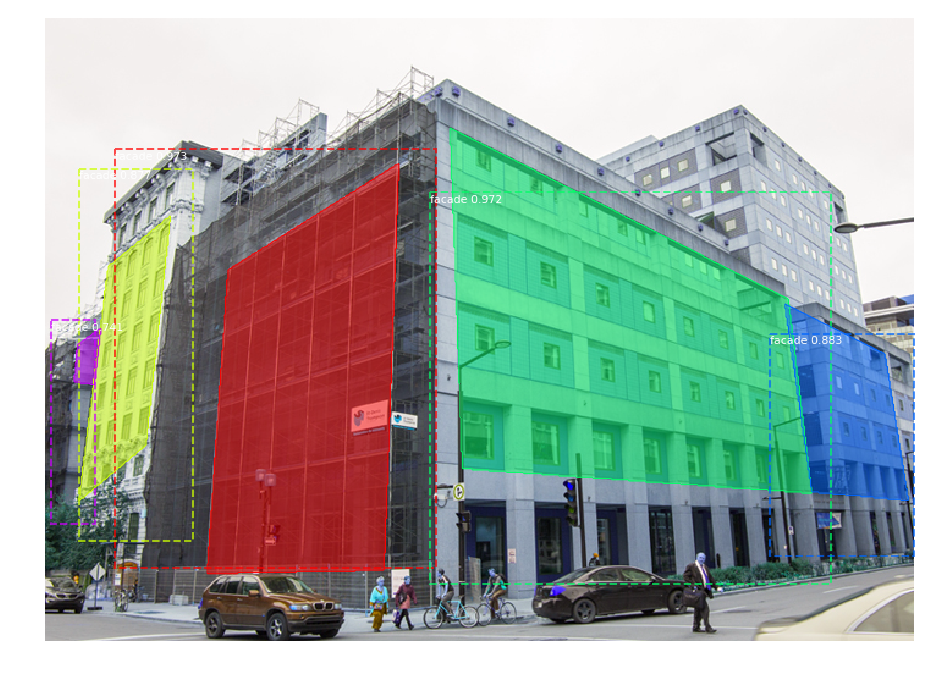

In [20]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.
    Returns closest integer pixel locations.
    """    
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

def midle_vline(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    rho = (rho1+rho2)/2
#     top1 = [int(rho1/np.cos(theta1)),0] #该直线与第一行的交点
#     top2 = [int(rho2/np.cos(theta2)),0] #该直线与第一行的交点
#     top = [(top1[0]+top2[0])/2, 0]
#     bt1 = (int((rho1-y_max*np.sin(theta1))/np.cos(theta1)),y_max)
#     bt2 = (int((rho2-y_max*np.sin(theta2))/np.cos(theta2)),y_max)
#     bt = [(bt1[0]+bt2[0])/2, y_max]
    theta = (theta1+theta2)/2
    line = [[rho, theta]]
    return line

    
def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    group = lines[0]
    next_group = lines[1]
    for line1 in group:
        for line2 in next_group:
            intersections.append(intersection(line1, line2)) 
    return intersections

def horizontal_lines_order(lines, building_details):
    scoles = []
    horizontal_lines = []
    top_30_lines = []
    for line in lines:
        rho = line[0][0] #第一个元素是距离rho 
        theta= line[0][1] #第二个元素是角度theta 
        if (theta > (6.*np.pi/18.0) and theta < (12.*np.pi/18.0)): #水平直线 
            black_image = np.zeros(building_details.shape).astype('uint8')  
            rho = line[0][0] #第一个元素是距离rho 
            theta= line[0][1] #第二个元素是角度theta
            # 该直线与第一列的交点 
            pt1 = (0,int(rho/np.sin(theta))) 
            #该直线与最后一列的交点 
            pt2 = (result.shape[1], int((rho-result.shape[1]*np.cos(theta))/np.sin(theta))) 
            cv2.line(black_image, pt1, pt2, (255), 1)
            line_scole = np.bitwise_and(black_image, building_details)
            scole = area(line_scole)
            scoles.append(scole)
            horizontal_lines.append(line)
    if len(horizontal_lines)>30:
        index = sorted(range(len(scoles)), key=lambda k: scoles[k])
        index.reverse()  
        for i in range(30):
            top_30_lines.append(lines[index[i]])
        return top_30_lines
    else:
        return horizontal_lines

result = image.copy()
for i in range(len(facades_mask)):   
    byproduction = image.copy()
    
    building_details = facades_mask[i]
    w = facades_w[i]
    h = facades_h[i]
    h_min = int(h/8)
    vertical_lines = cv2.HoughLines(building_details,1,np.pi/180,h_min)
    max_vertical = -1
    min_vertical = 30000
    max_vindex = -1
    min_vindex = 30000
    # print(vertical_lines)
    # print("###########################")
    num_max = math.sqrt((w/building_details.shape[1]))*20
    #num_max = (w/building_details.shape[1])*20
    if vertical_lines is not None:
        num = 0
        for k, line in enumerate(vertical_lines):
            if num>num_max:
                break
            rho = line[0][0] #第一个元素是距离rho 
            theta= line[0][1] #第二个元素是角度theta 
            if (theta < (1.5*np.pi/18. )) or (theta > (16.*np.pi/18.0)): #垂直直线 
                num += 1
                pt1 = (int(rho/np.cos(theta)),0) #该直线与第一行的交点
                #该直线与最后一行的焦点 
                pt2 = (int((rho-result.shape[0]*np.sin(theta))/np.cos(theta)),result.shape[0])
                cv2.line(byproduction, pt1, pt2, (255)) # 绘制一条白线
                if (int(rho/np.cos(theta)) > max_vertical):
                    max_vertical = rho/np.cos(theta)
                    max_vindex = k
                elif (int(rho/np.cos(theta))< min_vertical):
                    min_vertical = rho/np.cos(theta)
                    min_vindex = k
    if min_vindex != 30000 and max_vindex != -1:
        medle_line = midle_vline(vertical_lines[max_vindex], vertical_lines[min_vindex])               
        if h/w>=2:
            horizontal_lines = cv2.HoughLines(building_details,1,np.pi/180,int(w/8))
            #horizontal_lines = horizontal_lines_order(horizontal_lines,building_details)
        else:
            horizontal_lines = cv2.HoughLines(building_details,1,np.pi/180,int(w/4))
            #horizontal_lines = horizontal_lines_order(horizontal_lines,building_details)
        max_horizontal = -1
        min_horizontal = 30000
        max_hindex = -1
        min_hindex = 30000
        #num_max = math.sqrt(h/building_details.shape[0])*30
        #num_max = (w/building_details.shape[1])*20
        num_max = math.sqrt((w/building_details.shape[1]))*20
        if horizontal_lines is not None:
            num = 0
            for j, line in enumerate(horizontal_lines):
                if num>num_max:
                    break
                rho = line[0][0] #第一个元素是距离rho 
                theta= line[0][1] #第二个元素是角度theta 
                if (theta > (5.*np.pi/18.0) and theta < (13.*np.pi/18.0)): #水平直线 
                    num +=1
                    pt1 = (0,int(rho/np.sin(theta))) # 该直线与第一列的交点
                    y = intersection(medle_line, line)[0][1]
                    #该直线与最后一列的交点 
                    pt2 = (result.shape[1], int((rho-result.shape[1]*np.cos(theta))/np.sin(theta))) 
                    cv2.line(byproduction, pt1, pt2, (255), 1)
#                     if (int(rho/np.sin(theta))> max_horizontal):
#                         max_horizontal = int(rho/np.sin(theta))
#                         max_hindex = j
#                     if (int(rho/np.sin(theta))< min_horizontal):
#                         min_horizontal = int(rho/np.sin(theta))
#                         min_hindex = j
                    if y>max_horizontal:
                        max_horizontal = y
                        max_hindex = j
                    elif y< min_horizontal:
                        min_horizontal = y
                        min_hindex = j                
    new_mask = np.zeros(building_details.shape, dtype = np.uint8)
    print(new_mask.shape)
    
    print(min_hindex,max_hindex,min_vindex, max_vindex)
    if(min_hindex != 30000 and min_vindex != 30000 and max_hindex != -1 and max_vindex != -1):
        segmented = [[vertical_lines[max_vindex], vertical_lines[min_vindex]], [horizontal_lines[max_hindex], horizontal_lines[min_hindex]] ]
        intersections = segmented_intersections(segmented)
    
        if len(intersections) == 4:
            points_ordered = np.array([intersections[0],intersections[1],intersections[3],intersections[2]])
            cv2.fillConvexPoly(new_mask, points_ordered, 255)
            for point in intersections:
                cv2.circle(byproduction, tuple(point[0]), 10, (0,0,255), thickness=2) 
                
    new_mask.astype(np.bool)
    r['masks'][:,:,i] = new_mask

    plt.figure(figsize=(50,50))
    plt.imshow(byproduction,plt.cm.gray)
    plt.show()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

    